# Credit scoring

The process of creating a credit scoring model.
To create the model I used the following process:
- exploratory data analysis, drew up a rough action plan
- filled in missing values in features, identified new features from the date, processed categorical features
- scaled the features using Standard Scaler
- splitted the dataset into training and test samples, taking into account class imbalance
- created and launched tracking metrics and model parameters using MLFlow
- compared LogisticRegression, RandomForestClassifier, CatboostClassifier

In [79]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.tracking import MlflowClient

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier

%matplotlib inline

In [38]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Credit_Scoring")

<Experiment: artifact_location='/Users/nikitaefremov/Documents/DATA_SCIENCE/Credit_Scoring/notebooks/mlruns/3', creation_time=1713111825585, experiment_id='3', last_update_time=1713111825585, lifecycle_stage='active', name='Credit_Scoring', tags={}>

____

In [39]:
df = pd.read_excel('../data/text_data_model.xlsx')

## EDA

In [40]:
df.describe(include='object')

id       x3    x4  \
count                                   2000     1987  2000   
unique                                  2000        6    11   
top     7ED6CC5B-6628-4873-9D4C-33455B29CC4C  Android  UMID   
freq                                       1     1783   491   

                                      x5             x6  \
count                               2000             34   
unique                              2000             34   
top     *******ynordemaala1985@gmail.com  +6390627*****   
freq                                   1              1   

                                                      x11  
count                                                2000  
unique                                                127  
top     [{"id": "E115", "name": "Domain is a free prov...  
freq                                                  810

In [41]:
df.describe(include='number')

x1             x2           x7           x8           x9  \
count  2000.000000    1976.000000  1953.000000  1943.000000  1982.000000   
mean     34.251812   22141.979757     0.292883     0.854864     0.838042   
std       8.953549   22189.029628     0.455202     0.352329     0.368505   
min      22.015058     250.000000     0.000000     0.000000     0.000000   
25%      27.338125   13000.000000     0.000000     1.000000     1.000000   
50%      32.243669   18500.000000     0.000000     1.000000     1.000000   
75%      39.380561   25000.000000     1.000000     1.000000     1.000000   
max      68.553046  400000.000000     1.000000     1.000000     1.000000   

               x10            y  
count  1943.000000  2000.000000  
mean      0.316006     0.352000  
std       0.465035     0.477713  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       1.000000     1.000000  
max       1.000000     1.000000

### TODO:

Categorical: \
id - delete \
x3 - to one hot encoding, only 6 values \
x4 - 11 values, one hot encoding or mean target encoding \
x5 - email, delete \
x6 - only 34 values. Delete or create binary feature \
x11 - a lot unique values - 127. Parse JSON and look what is inside

Numerical: \
x1 - there is no missing values \
x2 - income? there is a few missing values \
x7 - binary column, 47 missing values \
x8 - binary column, 57 missing values \
x9 - binary column, 18 missing values \
x10 - binary column, 57 missing values \
y - target, there is no missing values 

Data: \
dt - data, get year, month, day of week

### Correlation between features

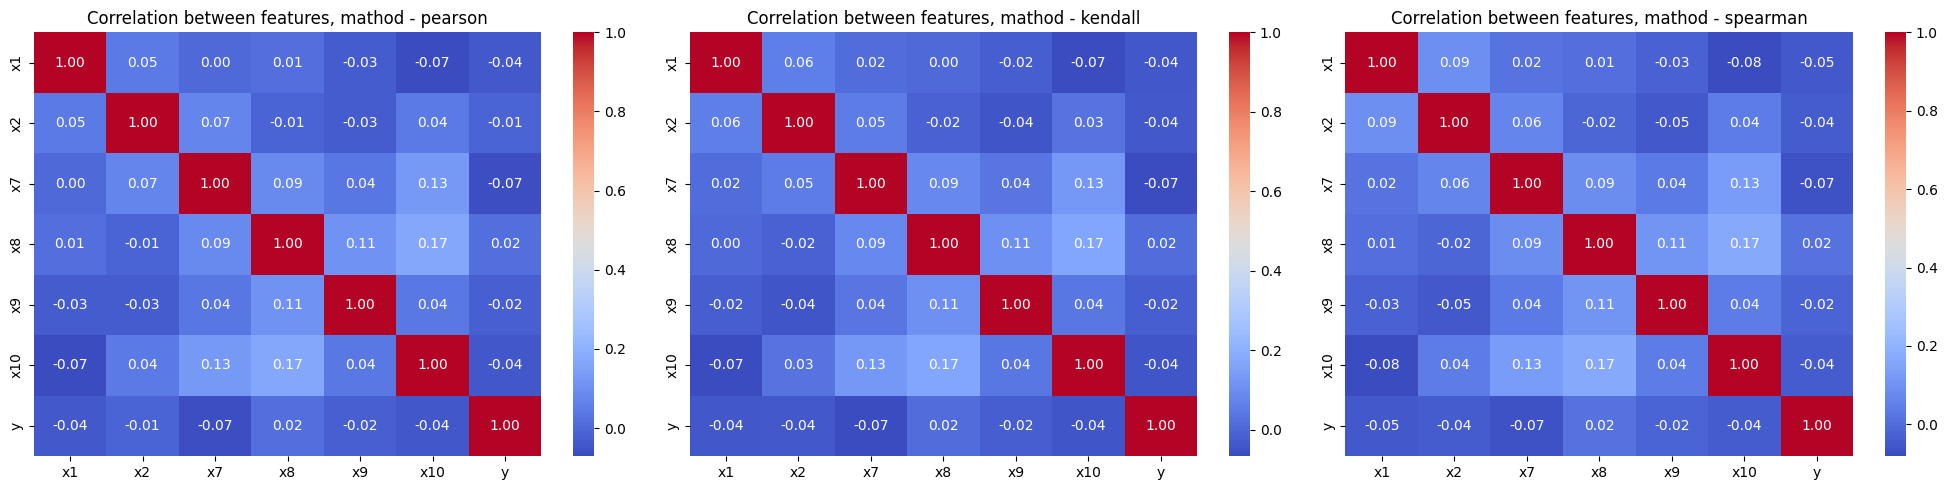

In [42]:
# Use 3 methods of correlation
methods = ['pearson', 'kendall', 'spearman']

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, method in enumerate(methods):
    corr_matrix = df[df.describe(include='number').columns].corr(method=method)
    sns.heatmap(corr_matrix, ax=axes[idx], annot=True, fmt=".2f", cmap='coolwarm')
    axes[idx].set_title(f'Correlation between features, mathod - {method}')


plt.tight_layout() 
plt.show()

There is no valuable correlation between features

In [43]:
df['y'].value_counts()

y
0    1296
1     704
Name: count, dtype: int64

There is a slight class imbalance

____

## Feature Engineering

In [44]:
# Delete index, email and phone numbers
df = df.drop(['id', 'x5', 'x6'], axis=1)

In [45]:
# Get month and day of week
df['month'] = df['dt'].dt.month
df['day_of_week'] = df['dt'].dt.day_of_week

df = df.drop('dt', axis=1)

In [46]:
# Fill missing values in x2 with median
# TODO: try mean, mode

df['x2'] = df['x2'].fillna(df.x2.median())

### Emissions

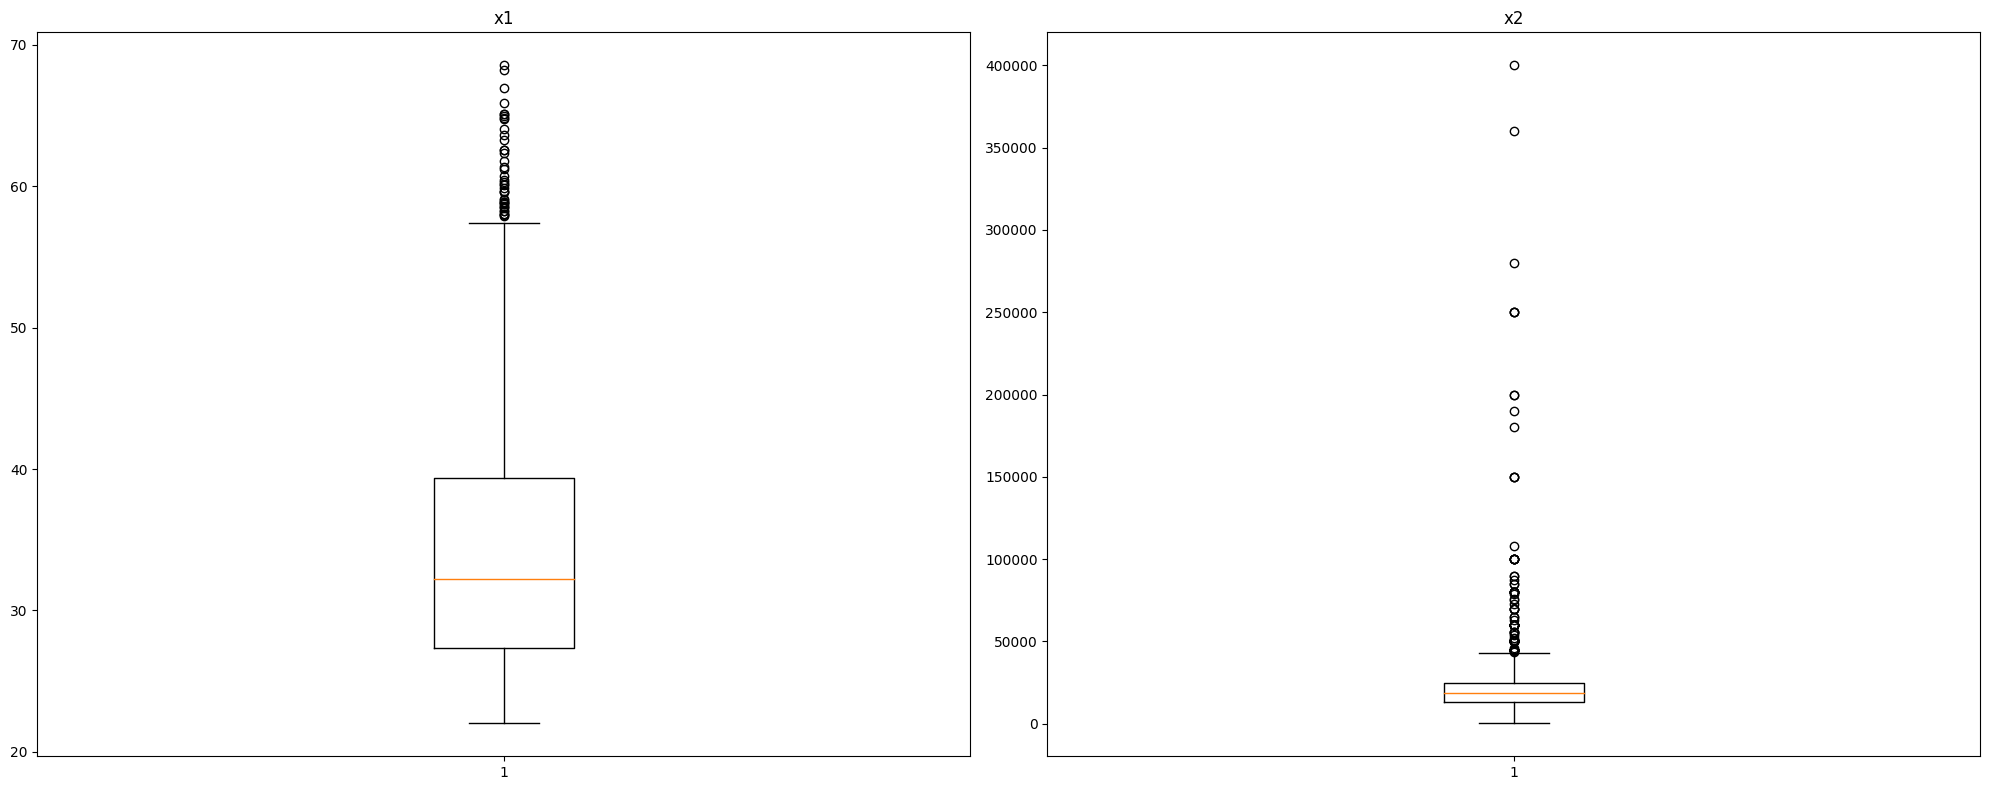

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

num_cols = ['x1', 'x2']
for idx, col in enumerate(num_cols):
    axes[idx].boxplot(df[col]) 
    axes[idx].set_title(f'{col}')

plt.tight_layout()
plt.show()    

There is no valuable emmisions in x1. \
Delete rows where values of x2 > 200000 for improving accuracy of models

In [48]:
df = df[df['x2'] < 200000]

In [49]:
# Fill the missing values in binary columns with mode and convert them to int type

cols = ['x7', 'x8', 'x9', 'x10']

for col in cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value).astype(int)

In [50]:
# Fill the missing values in categorical columns with mode
cat_cols = ['x3', 'x4']

for col in cat_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

In [51]:
# Control check for missing values
df.isna().sum()

x1             0
x2             0
x3             0
x4             0
x7             0
x8             0
x9             0
x10            0
x11            0
y              0
month          0
day_of_week    0
dtype: int64

#### Parse JSON

In [52]:
def safe_json_loads(s):
    try:
        return json.loads(s)
    except ValueError:
        return None 

df['x11'] = df['x11'].apply(safe_json_loads)

In [53]:
def calculate_score_stats(dicts):
    scores = [d.get('score') for d in dicts if 'score' in d]
    if not scores: 
        return {'total_score': None, 'max_score': None, 'min_score': None}
    total_score = sum(scores)
    max_score = max(scores)
    min_score = min(scores)
    mean_score = sum(scores) / len(scores)
    return {'total_score': total_score, 'max_score': max_score, 'min_score': min_score, 'mean_score': mean_score}

In [54]:
new_features_df = pd.DataFrame()

In [55]:
new_features_df[['total_score', 'max_score', 'min_score', 'mean_score']] = df['x11'].apply(lambda x: pd.Series(calculate_score_stats(x)))

In [56]:
new_features_df.head()

total_score  max_score  min_score  mean_score
0          1.0        1.0        0.0         0.5
1          1.0        1.0        0.0         0.5
2          1.0        1.0        0.0         0.5
3          1.0        1.0        0.0         0.5
4          3.0        2.0        0.0         1.0

In [57]:
df = df.drop('x11', axis=1)
df = pd.concat([df, new_features_df], axis=1)

#### Correlation of new features between themselves and the target variable

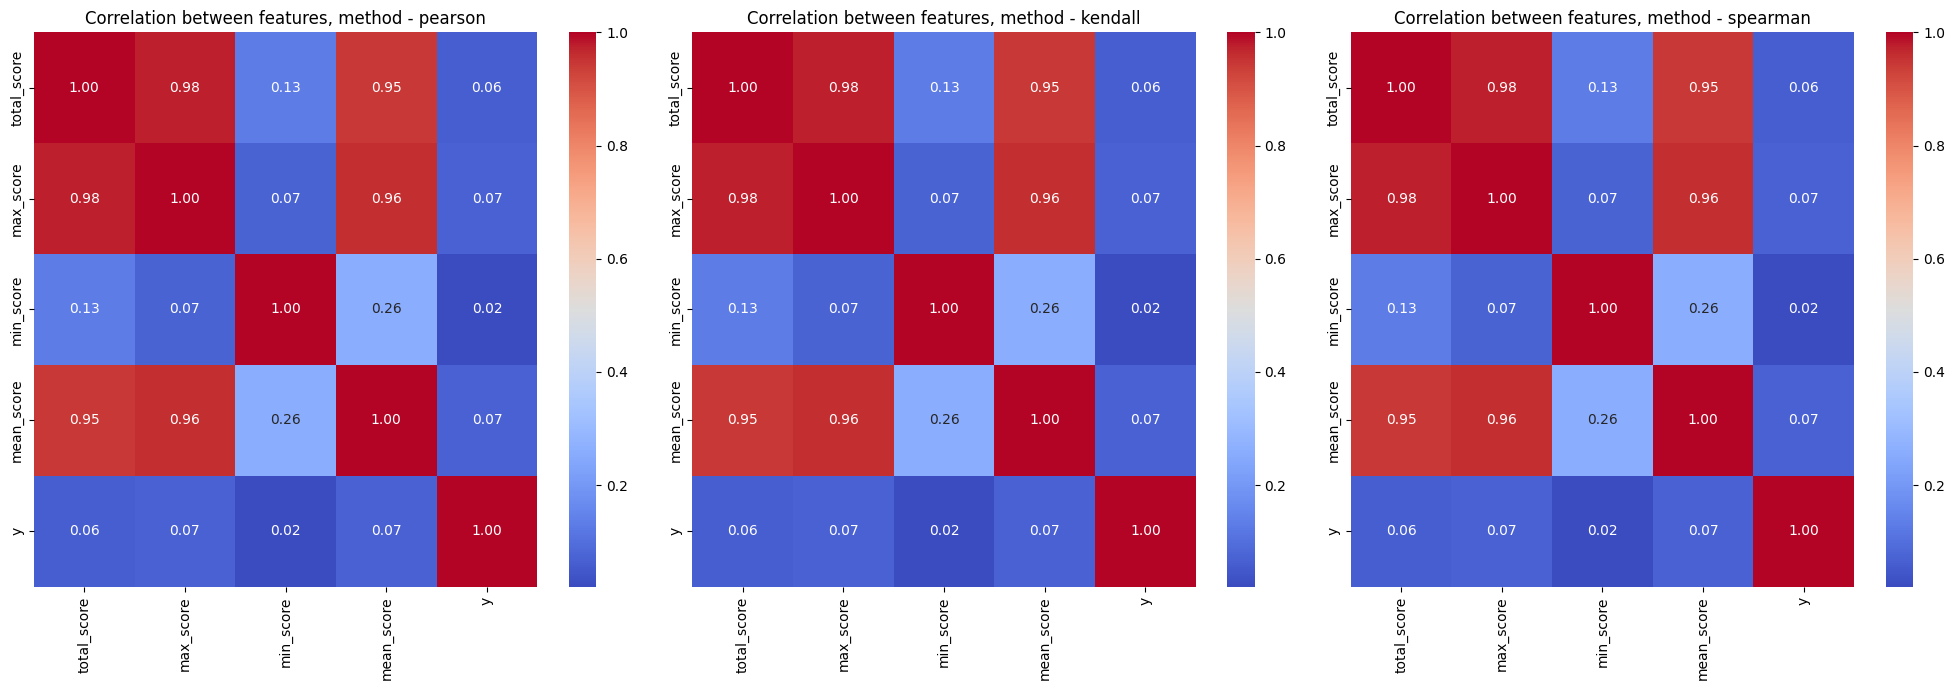

In [58]:
methods = ['pearson', 'kendall', 'spearman']

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, method in enumerate(methods):
    score_corr_matrix = df[['total_score', 'max_score', 'min_score', 'mean_score', 'y']].corr()
    sns.heatmap(score_corr_matrix, ax=axes[idx], annot=True, fmt=".2f", cmap='coolwarm')
    axes[idx].set_title(f'Correlation between features, method - {method}')


plt.tight_layout() 
plt.show()

There is no obvious correlation between the traits and the target variable, but there is a strong correlation between each other.

To train the model we will use max_score and min_score

In [59]:
df.drop(['total_score', 'mean_score'], axis=1, inplace=True)

#### One Hot Encoding

In [60]:
# Copy dataframe to use processing of categorical features in Catboost
df_for_cat = df.copy()

In [61]:
ohe_cols = ['x3', 'x4']

In [62]:
df = pd.get_dummies(df, columns=ohe_cols, dtype=int)

____

## Scaler

In [63]:
scaler = StandardScaler()

In [64]:
numerical_features_df = [i for i in df.describe(include='number').columns]

numerical_features_df_cf = [i for i in df_for_cat.describe(include='number')]

In [65]:
numerical_features_df.remove('y')
numerical_features_df_cf.remove('y')

In [66]:
df[numerical_features_df] = scaler.fit_transform(df[numerical_features_df])
df_for_cat[numerical_features_df_cf] = scaler.fit_transform(df_for_cat[numerical_features_df_cf])

___

In [67]:
df.head()

x1        x2        x7        x8        x9       x10  y     month  \
0  0.306617  0.198673  1.581417  0.405255  0.437479  1.503406  0  0.723948   
1 -0.778712 -0.347062 -0.632344  0.405255  0.437479 -0.665156  0  0.723948   
2 -0.797361  0.266890 -0.632344  0.405255  0.437479  1.503406  1  0.723948   
3 -0.316759  0.607974 -0.632344  0.405255  0.437479 -0.665156  1  0.723948   
4  0.128378  0.607974  1.581417  0.405255 -2.285826 -0.665156  1  0.723948   

   day_of_week  max_score  ...      x4_7     x4_18     x4_20     x4_21  \
0    -1.014434  -0.373272  ... -0.265315 -0.050163 -0.119401 -0.174707   
1    -1.014434  -0.373272  ... -0.265315 -0.050163 -0.119401 -0.174707   
2    -0.290669  -0.373272  ... -0.265315 -0.050163 -0.119401 -0.174707   
3    -0.290669  -0.373272  ... -0.265315 -0.050163 -0.119401 -0.174707   
4    -1.014434   0.015822  ... -0.265315 -0.050163 -0.119401 -0.174707   

   x4_Driver license ID    x4_PRC  x4_Passport    x4_SSS    x4_TIN   x4_UMID  
0              2.007561 -0.166924      -0.3171 -0.239426 -0.411947 -0.569621  
1              2.007561 -0.166924      -0.3171 -0.239426 -0.411947 -0.569621  
2             -0.498117 -0.166924      -0.3171 -0.239426  2.427495 -0.569621  
3             -0.498117 -0.166924      -0.3171 -0.239426 -0.411947  1.755553  
4             -0.498117 -0.166924      -0.3171 -0.239426 -0.411947 -0.569621  

[5 rows x 28 columns]

In [68]:
df_for_cat.head()

x1        x2       x3                 x4        x7        x8  \
0  0.306617  0.198673  Android  Driver license ID  1.581417  0.405255   
1 -0.778712 -0.347062  Android  Driver license ID -0.632344  0.405255   
2 -0.797361  0.266890  Android                TIN -0.632344  0.405255   
3 -0.316759  0.607974  Android               UMID -0.632344  0.405255   
4  0.128378  0.607974  Android                  4  1.581417  0.405255   

         x9       x10  y     month  day_of_week  max_score  min_score  
0  0.437479  1.503406  0  0.723948    -1.014434  -0.373272  -0.212474  
1  0.437479 -0.665156  0  0.723948    -1.014434  -0.373272  -0.212474  
2  0.437479  1.503406  1  0.723948    -0.290669  -0.373272  -0.212474  
3  0.437479 -0.665156  1  0.723948    -0.290669  -0.373272  -0.212474  
4 -2.285826 -0.665156  1  0.723948    -1.014434   0.015822  -0.212474

___

## Train test split

In [69]:
X = df.drop('y', axis=1)
y = df['y']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Logistic Regression

In [71]:
with mlflow.start_run():

    # Initialize parameters
    params = {
        'max_iter': 1000,
        'penalty': 'l1',
        'solver': 'liblinear'
    }

    # Log model name and parameters
    mlflow.set_tag('model_name', 'Logistic_Regression')
    mlflow.log_params(params)

    # Train the model
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)

    # Predict
    y_hat_train = model.predict_proba(X_train)[:, 1]
    y_hat_test = model.predict_proba(X_test)[:, 1]
    
    # Get metrics
    roc_auc_train = roc_auc_score(y_train, y_hat_train)
    gini_train = 2 * roc_auc_train - 1
    roc_auc_test = roc_auc_score(y_test, y_hat_test) 
    gini_test = 2 * roc_auc_test - 1

    # Log metrics and model
    mlflow.log_metric('gini_train', gini_train)
    mlflow.log_metric('gini_test', gini_test)
    mlflow.sklearn.log_model(model, 'sk_models')

## Random Forest

In [72]:
with mlflow.start_run():

    # Initialize parameters
    params = {
        'n_estimators': 100,
        'max_depth': 100,
        'min_samples_split': 10,
        'min_samples_leaf': 4,
        'criterion': 'gini'
    }

    # Log model name and parameters
    mlflow.set_tag('model_name', 'RandomForestClassifier')
    mlflow.log_params(params)

    # Train the model
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)

    # Predict
    y_hat_train = model.predict_proba(X_train)[:, 1]
    y_hat_test = model.predict_proba(X_test)[:, 1]
    
    # Get metrics
    roc_auc_train = roc_auc_score(y_train, y_hat_train)
    gini_train = 2 * roc_auc_train - 1
    roc_auc_test = roc_auc_score(y_test, y_hat_test)
    gini_test = 2 * roc_auc_test - 1

    # Log metrics and model
    mlflow.log_metric('gini_train', gini_train)
    mlflow.log_metric('gini_test', gini_test)
    mlflow.sklearn.log_model(model, 'RF_models')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## CatBoost

In [73]:
with mlflow.start_run():

    # Initialize parameters
    params = {
        'iterations': 1000,
        'learning_rate': 0.01,
        'depth': 5,
        'cat_features': None,
        'verbose': 0
    }

    # Log model name and parameters
    mlflow.set_tag('model_name', 'CatBoostClassifier')
    mlflow.log_params(params)

    # Train the model
    # model = CatBoostClassifier(verbose=0)
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    # Predict
    y_hat_train = model.predict_proba(X_train)[:, 1]
    y_hat_test = model.predict_proba(X_test)[:, 1]
    
    # Get metrics
    roc_auc_train = roc_auc_score(y_train, y_hat_train)
    gini_train = 2 * roc_auc_train - 1
    roc_auc_test = roc_auc_score(y_test, y_hat_test)
    gini_test = 2 * roc_auc_test - 1

    # Log metrics and model
    mlflow.log_metric('gini_train', gini_train)
    mlflow.log_metric('gini_test', gini_test)
    mlflow.catboost.log_model(model, 'CB_models')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Catboost, batch categorical features

In [74]:
df_for_cat.head()

x1        x2       x3                 x4        x7        x8  \
0  0.306617  0.198673  Android  Driver license ID  1.581417  0.405255   
1 -0.778712 -0.347062  Android  Driver license ID -0.632344  0.405255   
2 -0.797361  0.266890  Android                TIN -0.632344  0.405255   
3 -0.316759  0.607974  Android               UMID -0.632344  0.405255   
4  0.128378  0.607974  Android                  4  1.581417  0.405255   

         x9       x10  y     month  day_of_week  max_score  min_score  
0  0.437479  1.503406  0  0.723948    -1.014434  -0.373272  -0.212474  
1  0.437479 -0.665156  0  0.723948    -1.014434  -0.373272  -0.212474  
2  0.437479  1.503406  1  0.723948    -0.290669  -0.373272  -0.212474  
3  0.437479 -0.665156  1  0.723948    -0.290669  -0.373272  -0.212474  
4 -2.285826 -0.665156  1  0.723948    -1.014434   0.015822  -0.212474

In [75]:
cat_features = [i for i in df_for_cat.describe(include='object').columns]

In [76]:
X_cat = df_for_cat.drop('y', axis=1)
y_cat = df_for_cat['y']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

In [77]:
with mlflow.start_run():

    # Initialize parameters
    params = {
        'iterations': 1000,
        'learning_rate': 0.01,
        'depth': 5,
        'cat_features': cat_features,
        'verbose': 0
    }

    # Log model name and parameters
    mlflow.set_tag('model_name', 'CatBoostClassifier_Cat_Features')
    mlflow.log_params(params)

    # Train the model
    # model = CatBoostClassifier(verbose=0)
    model = CatBoostClassifier(**params)
    model.fit(X_train_cat, y_train_cat)

    # Predict
    y_hat_train = model.predict_proba(X_train_cat)[:, 1]
    y_hat_test = model.predict_proba(X_test_cat)[:, 1]
    
    # Get metrics
    roc_auc_train = roc_auc_score(y_train_cat, y_hat_train)
    gini_train = 2 * roc_auc_train - 1
    roc_auc_test = roc_auc_score(y_test_cat, y_hat_test) 
    gini_test = 2 * roc_auc_test - 1 

    # Log metrics and model
    mlflow.log_metric('gini_train', gini_train)
    mlflow.log_metric('gini_test', gini_test)
    mlflow.catboost.log_model(model, 'CB_models_CAT_FEATURES')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


____

## Get info about best experiment

In [90]:
experiment = client.get_experiment_by_name("Credit_Scoring")
experiment_id = experiment.experiment_id

In [92]:
client = mlflow.tracking.MlflowClient()

In [94]:
best_run = client.search_runs(
    experiment_ids=[experiment_id],
    order_by=["metrics.gini_test DESC"],
    max_results=1
)[0]

In [98]:
print("Metrics:")
for metric, value in best_run.data.metrics.items():
    print(f"{metric}: {value}")

print("\nParameters:")
for param, value in best_run.data.params.items():
    print(f"{param}: {value}")

Metrics:
gini_train: 0.2166915391949591
gini_test: 0.24561500275786008

Parameters:
max_iter: 1000
penalty: l1
solver: liblinear


____